In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-18 15:32:06.429895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-18 15:32:06.430004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-18 15:32:06.430015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"
config.model.reference_process_key = "ula"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "ion")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais"  or config.model.reference_process_key == "ula":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False
    config.trainer.lr_sch_base_dec = 1.0
    config.trainer.learning_rate = 1 * 10**(-5)
    
    if config.task == "funnel": # lnZ: 0.4, ELBO: 1.6
        config.model.sigma = 1.25
        config.model.sigma_base = 1.75
        config.trainer.learning_rate = 1 * 10**(-5)
        config.trainer.lr_sch_base_dec = 0.95 # For funnel
        
    if config.task == "lr_sonar": # lnZ: -109.1, ELBO: -114.76
        config.model.sigma = 0.5
        config.model.sigma_base = 0.6
    
    if config.task == "ion":     # lnZ: -112.275, ELBO: -117.619
        config.model.sigma = 0.5
        config.model.sigma_base = 0.7
    
    if config.task == "lgcp":  # lnZ: 473, ELBO: 413
        config.model.sigma = 4.6
        config.model.sigma_base = 2.3
    


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
# config.trainer.learning_rate = 5 * 10**(-3)

# config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 6000
# config.trainer.epochs = 1
config.model.sigma, config.model.sigma_base

(0.5, 0.7)

In [3]:
config.trainer.epochs, config.model.reference_process_key

(6000, 'ula')

In [4]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

if config.model.reference_process_key == "oudstl":
    config.model.sigma_base = config.model.sigma

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma_base * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [5]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7fc7f81caa70>, apply=<function transform_with_state.<locals>.apply_fn at 0x7fc7f81cac20>)


In [6]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [7]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

print("TRAINING COMPLETED")
loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 206.39439392089844)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 206.39439392089844)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 208.6587371826172)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 209.9688262939453)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 200.20449829101562)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 202.0572967529297)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 205.4791259765625)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 201.81781005859375)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 213.96060180664062)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 218.14967346191406)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 207.42381286621094)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 207.03070068359375)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 212.29806518554688)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 207.658203125)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 206.20179748535156)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 217.9032440185547)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 206.07003784179688)


('epoch: %s %s  loss: %s', 140, 'TRAIN', 209.27890014648438)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 200.3417205810547)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 209.00808715820312)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 208.28440856933594)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 206.77206420898438)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 202.77456665039062)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 200.32244873046875)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 221.80792236328125)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 199.32266235351562)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 214.59585571289062)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 215.01626586914062)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 210.2734375)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 204.92929077148438)
('epoch: %s %s  loss: %s', 153, 'TRAIN', 203.03651428222656)
('epoch: %s %s  loss: %s', 154, 'TRAIN', 211.857421875)
('epoch: %s %s  loss: %s', 155, 'TRAIN', 198.7239532470703)
('epoch: %s %s  loss: %s', 156, 'TRAIN

('epoch: %s %s  loss: %s', 278, 'TRAIN', 204.07505798339844)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 201.73561096191406)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 197.9925079345703)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 210.12989807128906)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 214.58628845214844)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 210.74874877929688)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 211.41162109375)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 204.0134735107422)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 210.88156127929688)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 204.3656005859375)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 211.15455627441406)
('epoch: %s %s  loss: %s', 289, 'TRAIN', 208.13677978515625)
('epoch: %s %s  loss: %s', 290, 'TRAIN', 199.74472045898438)
('epoch: %s %s  loss: %s', 291, 'TRAIN', 199.5322723388672)
('epoch: %s %s  loss: %s', 292, 'TRAIN', 197.47276306152344)
('epoch: %s %s  loss: %s', 293, 'TRAIN', 211.50257873535156)
('epoch: %s %s  loss: %s', 294,

('epoch: %s %s  loss: %s', 415, 'TRAIN', 217.47109985351562)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 199.2886505126953)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 211.4307403564453)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 198.5303955078125)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 203.50875854492188)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 208.93199157714844)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 207.6918487548828)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 201.15313720703125)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 217.6547393798828)
('epoch: %s %s  loss: %s', 424, 'TRAIN', 202.47792053222656)
('epoch: %s %s  loss: %s', 425, 'TRAIN', 217.94772338867188)
('epoch: %s %s  loss: %s', 426, 'TRAIN', 206.0441436767578)
('epoch: %s %s  loss: %s', 427, 'TRAIN', 209.06640625)
('epoch: %s %s  loss: %s', 428, 'TRAIN', 200.23135375976562)
('epoch: %s %s  loss: %s', 429, 'TRAIN', 203.04251098632812)
('epoch: %s %s  loss: %s', 430, 'TRAIN', 198.65023803710938)
('epoch: %s %s  loss: %s', 431, 'TRA

('epoch: %s %s  loss: %s', 551, 'TRAIN', 211.3869171142578)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 211.75726318359375)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 202.84437561035156)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 208.80006408691406)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 205.91664123535156)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 211.850830078125)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 201.65008544921875)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 205.01560974121094)
('epoch: %s %s  loss: %s', 559, 'TRAIN', 211.48782348632812)
('epoch: %s %s  loss: %s', 560, 'TRAIN', 210.43856811523438)
('epoch: %s %s  loss: %s', 561, 'TRAIN', 202.89256286621094)
('epoch: %s %s  loss: %s', 562, 'TRAIN', 209.10606384277344)
('epoch: %s %s  loss: %s', 563, 'TRAIN', 207.75570678710938)
('epoch: %s %s  loss: %s', 564, 'TRAIN', 204.68310546875)
('epoch: %s %s  loss: %s', 565, 'TRAIN', 216.8566436767578)
('epoch: %s %s  loss: %s', 566, 'TRAIN', 198.45338439941406)
('epoch: %s %s  loss: %s', 567,

('epoch: %s %s  loss: %s', 691, 'TRAIN', 208.5430145263672)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 197.4855194091797)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 210.17501831054688)
('epoch: %s %s  loss: %s', 694, 'TRAIN', 207.23043823242188)
('epoch: %s %s  loss: %s', 695, 'TRAIN', 200.62249755859375)
('epoch: %s %s  loss: %s', 696, 'TRAIN', 207.75111389160156)
('epoch: %s %s  loss: %s', 697, 'TRAIN', 206.38829040527344)
('epoch: %s %s  loss: %s', 698, 'TRAIN', 213.85565185546875)
('epoch: %s %s  loss: %s', 699, 'TRAIN', 194.43800354003906)
('epoch: %s %s  loss: %s', 700, 'TRAIN', 214.38185119628906)
('epoch: %s %s  loss: %s', 701, 'TRAIN', 201.9749755859375)
('epoch: %s %s  loss: %s', 702, 'TRAIN', 209.5732879638672)
('epoch: %s %s  loss: %s', 703, 'TRAIN', 206.48410034179688)
('epoch: %s %s  loss: %s', 704, 'TRAIN', 192.7901153564453)
('epoch: %s %s  loss: %s', 705, 'TRAIN', 198.8227996826172)
('epoch: %s %s  loss: %s', 706, 'TRAIN', 200.4802703857422)
('epoch: %s %s  loss: %s', 707,

('epoch: %s %s  loss: %s', 831, 'TRAIN', 197.44085693359375)
('epoch: %s %s  loss: %s', 832, 'TRAIN', 197.07266235351562)
('epoch: %s %s  loss: %s', 833, 'TRAIN', 209.83448791503906)
('epoch: %s %s  loss: %s', 834, 'TRAIN', 212.0940399169922)
('epoch: %s %s  loss: %s', 835, 'TRAIN', 203.08966064453125)
('epoch: %s %s  loss: %s', 836, 'TRAIN', 218.53036499023438)
('epoch: %s %s  loss: %s', 837, 'TRAIN', 209.7283935546875)
('epoch: %s %s  loss: %s', 838, 'TRAIN', 210.1967010498047)
('epoch: %s %s  loss: %s', 839, 'TRAIN', 209.94717407226562)
('epoch: %s %s  loss: %s', 840, 'TRAIN', 201.52540588378906)
('epoch: %s %s  loss: %s', 841, 'TRAIN', 196.8311767578125)
('epoch: %s %s  loss: %s', 842, 'TRAIN', 200.31747436523438)
('epoch: %s %s  loss: %s', 843, 'TRAIN', 213.43072509765625)
('epoch: %s %s  loss: %s', 844, 'TRAIN', 214.610107421875)
('epoch: %s %s  loss: %s', 845, 'TRAIN', 217.4234161376953)
('epoch: %s %s  loss: %s', 846, 'TRAIN', 209.5636749267578)
('epoch: %s %s  loss: %s', 847, 

('epoch: %s %s  loss: %s', 967, 'TRAIN', 209.72903442382812)
('epoch: %s %s  loss: %s', 968, 'TRAIN', 206.2386016845703)
('epoch: %s %s  loss: %s', 969, 'TRAIN', 208.9722137451172)
('epoch: %s %s  loss: %s', 970, 'TRAIN', 205.6004180908203)
('epoch: %s %s  loss: %s', 971, 'TRAIN', 205.92120361328125)
('epoch: %s %s  loss: %s', 972, 'TRAIN', 207.26756286621094)
('epoch: %s %s  loss: %s', 973, 'TRAIN', 213.12852478027344)
('epoch: %s %s  loss: %s', 974, 'TRAIN', 203.2386016845703)
('epoch: %s %s  loss: %s', 975, 'TRAIN', 204.4866485595703)
('epoch: %s %s  loss: %s', 976, 'TRAIN', 211.37771606445312)
('epoch: %s %s  loss: %s', 977, 'TRAIN', 203.90066528320312)
('epoch: %s %s  loss: %s', 978, 'TRAIN', 201.2138214111328)
('epoch: %s %s  loss: %s', 979, 'TRAIN', 214.03404235839844)
('epoch: %s %s  loss: %s', 980, 'TRAIN', 201.57095336914062)
('epoch: %s %s  loss: %s', 981, 'TRAIN', 207.142822265625)
('epoch: %s %s  loss: %s', 982, 'TRAIN', 205.79627990722656)
('epoch: %s %s  loss: %s', 983, 

('epoch: %s %s  loss: %s', 1104, 'TRAIN', 203.4148712158203)
('epoch: %s %s  loss: %s', 1105, 'TRAIN', 207.089111328125)
('epoch: %s %s  loss: %s', 1106, 'TRAIN', 209.74014282226562)
('epoch: %s %s  loss: %s', 1107, 'TRAIN', 206.185546875)
('epoch: %s %s  loss: %s', 1108, 'TRAIN', 212.4847869873047)
('epoch: %s %s  loss: %s', 1109, 'TRAIN', 208.46917724609375)
('epoch: %s %s  loss: %s', 1110, 'TRAIN', 203.6792755126953)
('epoch: %s %s  loss: %s', 1111, 'TRAIN', 205.5498046875)
('epoch: %s %s  loss: %s', 1112, 'TRAIN', 199.5144805908203)
('epoch: %s %s  loss: %s', 1113, 'TRAIN', 207.30706787109375)
('epoch: %s %s  loss: %s', 1114, 'TRAIN', 205.26315307617188)
('epoch: %s %s  loss: %s', 1115, 'TRAIN', 204.41567993164062)
('epoch: %s %s  loss: %s', 1116, 'TRAIN', 203.37303161621094)
('epoch: %s %s  loss: %s', 1117, 'TRAIN', 211.92921447753906)
('epoch: %s %s  loss: %s', 1118, 'TRAIN', 200.39462280273438)
('epoch: %s %s  loss: %s', 1119, 'TRAIN', 202.859375)
('epoch: %s %s  loss: %s', 1120

('epoch: %s %s  loss: %s', 1242, 'TRAIN', 202.90171813964844)
('epoch: %s %s  loss: %s', 1243, 'TRAIN', 204.21241760253906)
('epoch: %s %s  loss: %s', 1244, 'TRAIN', 205.95985412597656)
('epoch: %s %s  loss: %s', 1245, 'TRAIN', 215.69696044921875)
('epoch: %s %s  loss: %s', 1246, 'TRAIN', 205.03187561035156)
('epoch: %s %s  loss: %s', 1247, 'TRAIN', 209.95635986328125)
('epoch: %s %s  loss: %s', 1248, 'TRAIN', 206.3673553466797)
('epoch: %s %s  loss: %s', 1249, 'TRAIN', 204.3905487060547)
('epoch: %s %s  loss: %s', 1250, 'TRAIN', 203.8643798828125)
('epoch: %s %s  loss: %s', 1251, 'TRAIN', 206.51089477539062)
('epoch: %s %s  loss: %s', 1252, 'TRAIN', 201.19664001464844)
('epoch: %s %s  loss: %s', 1253, 'TRAIN', 207.54884338378906)
('epoch: %s %s  loss: %s', 1254, 'TRAIN', 202.6917724609375)
('epoch: %s %s  loss: %s', 1255, 'TRAIN', 208.57034301757812)
('epoch: %s %s  loss: %s', 1256, 'TRAIN', 207.982421875)
('epoch: %s %s  loss: %s', 1257, 'TRAIN', 204.62417602539062)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 1379, 'TRAIN', 204.11363220214844)
('epoch: %s %s  loss: %s', 1380, 'TRAIN', 206.6600799560547)
('epoch: %s %s  loss: %s', 1381, 'TRAIN', 203.44479370117188)
('epoch: %s %s  loss: %s', 1382, 'TRAIN', 204.2934112548828)
('epoch: %s %s  loss: %s', 1383, 'TRAIN', 201.9477081298828)
('epoch: %s %s  loss: %s', 1384, 'TRAIN', 207.9957275390625)
('epoch: %s %s  loss: %s', 1385, 'TRAIN', 202.34945678710938)
('epoch: %s %s  loss: %s', 1386, 'TRAIN', 196.50868225097656)
('epoch: %s %s  loss: %s', 1387, 'TRAIN', 202.4756622314453)
('epoch: %s %s  loss: %s', 1388, 'TRAIN', 203.46165466308594)
('epoch: %s %s  loss: %s', 1389, 'TRAIN', 202.92628479003906)
('epoch: %s %s  loss: %s', 1390, 'TRAIN', 211.24378967285156)
('epoch: %s %s  loss: %s', 1391, 'TRAIN', 198.7975616455078)
('epoch: %s %s  loss: %s', 1392, 'TRAIN', 205.74598693847656)
('epoch: %s %s  loss: %s', 1393, 'TRAIN', 209.0092010498047)
('epoch: %s %s  loss: %s', 1394, 'TRAIN', 214.7660675048828)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 1516, 'TRAIN', 201.2310791015625)
('epoch: %s %s  loss: %s', 1517, 'TRAIN', 214.77987670898438)
('epoch: %s %s  loss: %s', 1518, 'TRAIN', 206.64700317382812)
('epoch: %s %s  loss: %s', 1519, 'TRAIN', 201.52883911132812)
('epoch: %s %s  loss: %s', 1520, 'TRAIN', 207.2870330810547)
('epoch: %s %s  loss: %s', 1521, 'TRAIN', 204.899169921875)
('epoch: %s %s  loss: %s', 1522, 'TRAIN', 215.6572723388672)
('epoch: %s %s  loss: %s', 1523, 'TRAIN', 194.8039093017578)
('epoch: %s %s  loss: %s', 1524, 'TRAIN', 204.46829223632812)
('epoch: %s %s  loss: %s', 1525, 'TRAIN', 211.105712890625)
('epoch: %s %s  loss: %s', 1526, 'TRAIN', 214.20953369140625)
('epoch: %s %s  loss: %s', 1527, 'TRAIN', 193.906982421875)
('epoch: %s %s  loss: %s', 1528, 'TRAIN', 205.40196228027344)
('epoch: %s %s  loss: %s', 1529, 'TRAIN', 200.00921630859375)
('epoch: %s %s  loss: %s', 1530, 'TRAIN', 200.57476806640625)
('epoch: %s %s  loss: %s', 1531, 'TRAIN', 212.80751037597656)
('epoch: %s %s  lo

('epoch: %s %s  loss: %s', 1656, 'TRAIN', 204.69387817382812)
('epoch: %s %s  loss: %s', 1657, 'TRAIN', 205.26837158203125)
('epoch: %s %s  loss: %s', 1658, 'TRAIN', 199.7086181640625)
('epoch: %s %s  loss: %s', 1659, 'TRAIN', 211.67689514160156)
('epoch: %s %s  loss: %s', 1660, 'TRAIN', 205.98863220214844)
('epoch: %s %s  loss: %s', 1661, 'TRAIN', 214.48721313476562)
('epoch: %s %s  loss: %s', 1662, 'TRAIN', 207.634521484375)
('epoch: %s %s  loss: %s', 1663, 'TRAIN', 205.16015625)
('epoch: %s %s  loss: %s', 1664, 'TRAIN', 199.5967559814453)
('epoch: %s %s  loss: %s', 1665, 'TRAIN', 205.96022033691406)
('epoch: %s %s  loss: %s', 1666, 'TRAIN', 201.30723571777344)
('epoch: %s %s  loss: %s', 1667, 'TRAIN', 210.5355224609375)
('epoch: %s %s  loss: %s', 1668, 'TRAIN', 206.6464080810547)
('epoch: %s %s  loss: %s', 1669, 'TRAIN', 195.8931884765625)
('epoch: %s %s  loss: %s', 1670, 'TRAIN', 203.927978515625)
('epoch: %s %s  loss: %s', 1671, 'TRAIN', 210.62161254882812)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 1794, 'TRAIN', 208.01881408691406)
('epoch: %s %s  loss: %s', 1795, 'TRAIN', 211.51907348632812)
('epoch: %s %s  loss: %s', 1796, 'TRAIN', 205.11212158203125)
('epoch: %s %s  loss: %s', 1797, 'TRAIN', 210.37684631347656)
('epoch: %s %s  loss: %s', 1798, 'TRAIN', 205.5887451171875)
('epoch: %s %s  loss: %s', 1799, 'TRAIN', 204.49713134765625)
('epoch: %s %s  loss: %s', 1800, 'TRAIN', 207.4771728515625)
('epoch: %s %s  loss: %s', 1801, 'TRAIN', 209.2892303466797)
('epoch: %s %s  loss: %s', 1802, 'TRAIN', 199.83485412597656)
('epoch: %s %s  loss: %s', 1803, 'TRAIN', 204.64451599121094)
('epoch: %s %s  loss: %s', 1804, 'TRAIN', 213.18402099609375)
('epoch: %s %s  loss: %s', 1805, 'TRAIN', 204.58547973632812)
('epoch: %s %s  loss: %s', 1806, 'TRAIN', 201.1460723876953)
('epoch: %s %s  loss: %s', 1807, 'TRAIN', 205.87472534179688)
('epoch: %s %s  loss: %s', 1808, 'TRAIN', 210.33131408691406)
('epoch: %s %s  loss: %s', 1809, 'TRAIN', 199.73606872558594)
('epoch: %s 

('epoch: %s %s  loss: %s', 1929, 'TRAIN', 216.07687377929688)
('epoch: %s %s  loss: %s', 1930, 'TRAIN', 203.8980712890625)
('epoch: %s %s  loss: %s', 1931, 'TRAIN', 215.3776092529297)
('epoch: %s %s  loss: %s', 1932, 'TRAIN', 202.73960876464844)
('epoch: %s %s  loss: %s', 1933, 'TRAIN', 206.80471801757812)
('epoch: %s %s  loss: %s', 1934, 'TRAIN', 206.9076385498047)
('epoch: %s %s  loss: %s', 1935, 'TRAIN', 200.6905059814453)
('epoch: %s %s  loss: %s', 1936, 'TRAIN', 208.12307739257812)
('epoch: %s %s  loss: %s', 1937, 'TRAIN', 205.20816040039062)
('epoch: %s %s  loss: %s', 1938, 'TRAIN', 203.13925170898438)
('epoch: %s %s  loss: %s', 1939, 'TRAIN', 214.08287048339844)
('epoch: %s %s  loss: %s', 1940, 'TRAIN', 215.4124755859375)
('epoch: %s %s  loss: %s', 1941, 'TRAIN', 206.53933715820312)
('epoch: %s %s  loss: %s', 1942, 'TRAIN', 212.1206512451172)
('epoch: %s %s  loss: %s', 1943, 'TRAIN', 212.7991180419922)
('epoch: %s %s  loss: %s', 1944, 'TRAIN', 200.31150817871094)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 2064, 'TRAIN', 201.95809936523438)
('epoch: %s %s  loss: %s', 2065, 'TRAIN', 204.8292694091797)
('epoch: %s %s  loss: %s', 2066, 'TRAIN', 207.90875244140625)
('epoch: %s %s  loss: %s', 2067, 'TRAIN', 193.682861328125)
('epoch: %s %s  loss: %s', 2068, 'TRAIN', 205.9284210205078)
('epoch: %s %s  loss: %s', 2069, 'TRAIN', 204.99391174316406)
('epoch: %s %s  loss: %s', 2070, 'TRAIN', 210.38055419921875)
('epoch: %s %s  loss: %s', 2071, 'TRAIN', 208.82516479492188)
('epoch: %s %s  loss: %s', 2072, 'TRAIN', 212.0371856689453)
('epoch: %s %s  loss: %s', 2073, 'TRAIN', 212.4121856689453)
('epoch: %s %s  loss: %s', 2074, 'TRAIN', 205.49476623535156)
('epoch: %s %s  loss: %s', 2075, 'TRAIN', 212.0903778076172)
('epoch: %s %s  loss: %s', 2076, 'TRAIN', 208.6338653564453)
('epoch: %s %s  loss: %s', 2077, 'TRAIN', 212.75381469726562)
('epoch: %s %s  loss: %s', 2078, 'TRAIN', 202.8877716064453)
('epoch: %s %s  loss: %s', 2079, 'TRAIN', 200.4566650390625)
('epoch: %s %s  lo

('epoch: %s %s  loss: %s', 2198, 'TRAIN', 208.7535400390625)
('epoch: %s %s  loss: %s', 2199, 'TRAIN', 209.37611389160156)
('epoch: %s %s  loss: %s', 2200, 'TRAIN', 209.64437866210938)
('epoch: %s %s  loss: %s', 2201, 'TRAIN', 194.6488800048828)
('epoch: %s %s  loss: %s', 2202, 'TRAIN', 201.75173950195312)
('epoch: %s %s  loss: %s', 2203, 'TRAIN', 204.52456665039062)
('epoch: %s %s  loss: %s', 2204, 'TRAIN', 215.39024353027344)
('epoch: %s %s  loss: %s', 2205, 'TRAIN', 209.86398315429688)
('epoch: %s %s  loss: %s', 2206, 'TRAIN', 207.48739624023438)
('epoch: %s %s  loss: %s', 2207, 'TRAIN', 206.1172332763672)
('epoch: %s %s  loss: %s', 2208, 'TRAIN', 198.46864318847656)
('epoch: %s %s  loss: %s', 2209, 'TRAIN', 201.34063720703125)
('epoch: %s %s  loss: %s', 2210, 'TRAIN', 205.85406494140625)
('epoch: %s %s  loss: %s', 2211, 'TRAIN', 196.97511291503906)
('epoch: %s %s  loss: %s', 2212, 'TRAIN', 201.06422424316406)
('epoch: %s %s  loss: %s', 2213, 'TRAIN', 210.42344665527344)
('epoch: %s

('epoch: %s %s  loss: %s', 2334, 'TRAIN', 203.63162231445312)
('epoch: %s %s  loss: %s', 2335, 'TRAIN', 208.969482421875)
('epoch: %s %s  loss: %s', 2336, 'TRAIN', 213.05821228027344)
('epoch: %s %s  loss: %s', 2337, 'TRAIN', 199.0679168701172)
('epoch: %s %s  loss: %s', 2338, 'TRAIN', 201.02626037597656)
('epoch: %s %s  loss: %s', 2339, 'TRAIN', 208.16737365722656)
('epoch: %s %s  loss: %s', 2340, 'TRAIN', 208.65542602539062)
('epoch: %s %s  loss: %s', 2341, 'TRAIN', 209.6453857421875)
('epoch: %s %s  loss: %s', 2342, 'TRAIN', 208.58975219726562)
('epoch: %s %s  loss: %s', 2343, 'TRAIN', 206.09214782714844)
('epoch: %s %s  loss: %s', 2344, 'TRAIN', 203.50537109375)
('epoch: %s %s  loss: %s', 2345, 'TRAIN', 204.82032775878906)
('epoch: %s %s  loss: %s', 2346, 'TRAIN', 208.89320373535156)
('epoch: %s %s  loss: %s', 2347, 'TRAIN', 201.7757110595703)
('epoch: %s %s  loss: %s', 2348, 'TRAIN', 205.08262634277344)
('epoch: %s %s  loss: %s', 2349, 'TRAIN', 204.44735717773438)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 2468, 'TRAIN', 204.50950622558594)
('epoch: %s %s  loss: %s', 2469, 'TRAIN', 199.94805908203125)
('epoch: %s %s  loss: %s', 2470, 'TRAIN', 207.2447967529297)
('epoch: %s %s  loss: %s', 2471, 'TRAIN', 198.59800720214844)
('epoch: %s %s  loss: %s', 2472, 'TRAIN', 212.66156005859375)
('epoch: %s %s  loss: %s', 2473, 'TRAIN', 201.95779418945312)
('epoch: %s %s  loss: %s', 2474, 'TRAIN', 204.14788818359375)
('epoch: %s %s  loss: %s', 2475, 'TRAIN', 208.5741729736328)
('epoch: %s %s  loss: %s', 2476, 'TRAIN', 206.19677734375)
('epoch: %s %s  loss: %s', 2477, 'TRAIN', 210.02769470214844)
('epoch: %s %s  loss: %s', 2478, 'TRAIN', 199.35289001464844)
('epoch: %s %s  loss: %s', 2479, 'TRAIN', 218.38633728027344)
('epoch: %s %s  loss: %s', 2480, 'TRAIN', 205.30947875976562)
('epoch: %s %s  loss: %s', 2481, 'TRAIN', 212.77520751953125)
('epoch: %s %s  loss: %s', 2482, 'TRAIN', 221.1002960205078)
('epoch: %s %s  loss: %s', 2483, 'TRAIN', 202.47093200683594)
('epoch: %s %s

('epoch: %s %s  loss: %s', 2604, 'TRAIN', 205.2321014404297)
('epoch: %s %s  loss: %s', 2605, 'TRAIN', 206.46998596191406)
('epoch: %s %s  loss: %s', 2606, 'TRAIN', 193.71665954589844)
('epoch: %s %s  loss: %s', 2607, 'TRAIN', 203.624267578125)
('epoch: %s %s  loss: %s', 2608, 'TRAIN', 201.22193908691406)
('epoch: %s %s  loss: %s', 2609, 'TRAIN', 212.9880828857422)
('epoch: %s %s  loss: %s', 2610, 'TRAIN', 206.44305419921875)
('epoch: %s %s  loss: %s', 2611, 'TRAIN', 211.70286560058594)
('epoch: %s %s  loss: %s', 2612, 'TRAIN', 210.8103790283203)
('epoch: %s %s  loss: %s', 2613, 'TRAIN', 209.54550170898438)
('epoch: %s %s  loss: %s', 2614, 'TRAIN', 206.59300231933594)
('epoch: %s %s  loss: %s', 2615, 'TRAIN', 199.45086669921875)
('epoch: %s %s  loss: %s', 2616, 'TRAIN', 204.2362518310547)
('epoch: %s %s  loss: %s', 2617, 'TRAIN', 210.7223663330078)
('epoch: %s %s  loss: %s', 2618, 'TRAIN', 193.6875)
('epoch: %s %s  loss: %s', 2619, 'TRAIN', 207.00123596191406)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 2742, 'TRAIN', 204.2283172607422)
('epoch: %s %s  loss: %s', 2743, 'TRAIN', 215.11422729492188)
('epoch: %s %s  loss: %s', 2744, 'TRAIN', 208.21250915527344)
('epoch: %s %s  loss: %s', 2745, 'TRAIN', 208.9998779296875)
('epoch: %s %s  loss: %s', 2746, 'TRAIN', 208.97262573242188)
('epoch: %s %s  loss: %s', 2747, 'TRAIN', 208.000732421875)
('epoch: %s %s  loss: %s', 2748, 'TRAIN', 200.4005584716797)
('epoch: %s %s  loss: %s', 2749, 'TRAIN', 204.26943969726562)
('epoch: %s %s  loss: %s', 2750, 'TRAIN', 206.6041259765625)
('epoch: %s %s  loss: %s', 2751, 'TRAIN', 212.34744262695312)
('epoch: %s %s  loss: %s', 2752, 'TRAIN', 201.67874145507812)
('epoch: %s %s  loss: %s', 2753, 'TRAIN', 206.14308166503906)
('epoch: %s %s  loss: %s', 2754, 'TRAIN', 204.70115661621094)
('epoch: %s %s  loss: %s', 2755, 'TRAIN', 212.47845458984375)
('epoch: %s %s  loss: %s', 2756, 'TRAIN', 204.7164306640625)
('epoch: %s %s  loss: %s', 2757, 'TRAIN', 206.600830078125)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 2879, 'TRAIN', 204.0958709716797)
('epoch: %s %s  loss: %s', 2880, 'TRAIN', 213.4476318359375)
('epoch: %s %s  loss: %s', 2881, 'TRAIN', 211.08538818359375)
('epoch: %s %s  loss: %s', 2882, 'TRAIN', 205.79750061035156)
('epoch: %s %s  loss: %s', 2883, 'TRAIN', 216.83096313476562)
('epoch: %s %s  loss: %s', 2884, 'TRAIN', 210.7256317138672)
('epoch: %s %s  loss: %s', 2885, 'TRAIN', 205.37001037597656)
('epoch: %s %s  loss: %s', 2886, 'TRAIN', 207.38442993164062)
('epoch: %s %s  loss: %s', 2887, 'TRAIN', 207.86534118652344)
('epoch: %s %s  loss: %s', 2888, 'TRAIN', 198.5147247314453)
('epoch: %s %s  loss: %s', 2889, 'TRAIN', 205.2362823486328)
('epoch: %s %s  loss: %s', 2890, 'TRAIN', 208.261962890625)
('epoch: %s %s  loss: %s', 2891, 'TRAIN', 211.86326599121094)
('epoch: %s %s  loss: %s', 2892, 'TRAIN', 202.4862823486328)
('epoch: %s %s  loss: %s', 2893, 'TRAIN', 200.08132934570312)
('epoch: %s %s  loss: %s', 2894, 'TRAIN', 197.5758056640625)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 3016, 'TRAIN', 210.82521057128906)
('epoch: %s %s  loss: %s', 3017, 'TRAIN', 204.45997619628906)
('epoch: %s %s  loss: %s', 3018, 'TRAIN', 212.5718536376953)
('epoch: %s %s  loss: %s', 3019, 'TRAIN', 206.55929565429688)
('epoch: %s %s  loss: %s', 3020, 'TRAIN', 203.41546630859375)
('epoch: %s %s  loss: %s', 3021, 'TRAIN', 202.67628479003906)
('epoch: %s %s  loss: %s', 3022, 'TRAIN', 202.99847412109375)
('epoch: %s %s  loss: %s', 3023, 'TRAIN', 201.95040893554688)
('epoch: %s %s  loss: %s', 3024, 'TRAIN', 212.93995666503906)
('epoch: %s %s  loss: %s', 3025, 'TRAIN', 200.49893188476562)
('epoch: %s %s  loss: %s', 3026, 'TRAIN', 200.32041931152344)
('epoch: %s %s  loss: %s', 3027, 'TRAIN', 208.31968688964844)
('epoch: %s %s  loss: %s', 3028, 'TRAIN', 208.03419494628906)
('epoch: %s %s  loss: %s', 3029, 'TRAIN', 209.35287475585938)
('epoch: %s %s  loss: %s', 3030, 'TRAIN', 204.87474060058594)
('epoch: %s %s  loss: %s', 3031, 'TRAIN', 214.1476287841797)
('epoch: %

('epoch: %s %s  loss: %s', 3151, 'TRAIN', 203.94219970703125)
('epoch: %s %s  loss: %s', 3152, 'TRAIN', 204.09982299804688)
('epoch: %s %s  loss: %s', 3153, 'TRAIN', 225.9501953125)
('epoch: %s %s  loss: %s', 3154, 'TRAIN', 209.53968811035156)
('epoch: %s %s  loss: %s', 3155, 'TRAIN', 206.05052185058594)
('epoch: %s %s  loss: %s', 3156, 'TRAIN', 215.00804138183594)
('epoch: %s %s  loss: %s', 3157, 'TRAIN', 206.38803100585938)
('epoch: %s %s  loss: %s', 3158, 'TRAIN', 199.61257934570312)
('epoch: %s %s  loss: %s', 3159, 'TRAIN', 196.41085815429688)
('epoch: %s %s  loss: %s', 3160, 'TRAIN', 201.34115600585938)
('epoch: %s %s  loss: %s', 3161, 'TRAIN', 206.1846923828125)
('epoch: %s %s  loss: %s', 3162, 'TRAIN', 213.53233337402344)
('epoch: %s %s  loss: %s', 3163, 'TRAIN', 208.4480743408203)
('epoch: %s %s  loss: %s', 3164, 'TRAIN', 200.95932006835938)
('epoch: %s %s  loss: %s', 3165, 'TRAIN', 207.84547424316406)
('epoch: %s %s  loss: %s', 3166, 'TRAIN', 203.67144775390625)
('epoch: %s %s

('epoch: %s %s  loss: %s', 3288, 'TRAIN', 203.90121459960938)
('epoch: %s %s  loss: %s', 3289, 'TRAIN', 214.96922302246094)
('epoch: %s %s  loss: %s', 3290, 'TRAIN', 212.6072235107422)
('epoch: %s %s  loss: %s', 3291, 'TRAIN', 198.24066162109375)
('epoch: %s %s  loss: %s', 3292, 'TRAIN', 205.31143188476562)
('epoch: %s %s  loss: %s', 3293, 'TRAIN', 203.94686889648438)
('epoch: %s %s  loss: %s', 3294, 'TRAIN', 213.72836303710938)
('epoch: %s %s  loss: %s', 3295, 'TRAIN', 203.00599670410156)
('epoch: %s %s  loss: %s', 3296, 'TRAIN', 200.76853942871094)
('epoch: %s %s  loss: %s', 3297, 'TRAIN', 204.2814178466797)
('epoch: %s %s  loss: %s', 3298, 'TRAIN', 202.45751953125)
('epoch: %s %s  loss: %s', 3299, 'TRAIN', 203.5681915283203)
('epoch: %s %s  loss: %s', 3300, 'TRAIN', 210.8648681640625)
('epoch: %s %s  loss: %s', 3301, 'TRAIN', 203.14776611328125)
('epoch: %s %s  loss: %s', 3302, 'TRAIN', 208.52272033691406)
('epoch: %s %s  loss: %s', 3303, 'TRAIN', 212.05735778808594)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 3423, 'TRAIN', 204.33731079101562)
('epoch: %s %s  loss: %s', 3424, 'TRAIN', 208.16307067871094)
('epoch: %s %s  loss: %s', 3425, 'TRAIN', 202.80438232421875)
('epoch: %s %s  loss: %s', 3426, 'TRAIN', 208.32789611816406)
('epoch: %s %s  loss: %s', 3427, 'TRAIN', 206.058349609375)
('epoch: %s %s  loss: %s', 3428, 'TRAIN', 211.1485137939453)
('epoch: %s %s  loss: %s', 3429, 'TRAIN', 214.21421813964844)
('epoch: %s %s  loss: %s', 3430, 'TRAIN', 205.85250854492188)
('epoch: %s %s  loss: %s', 3431, 'TRAIN', 203.2593231201172)
('epoch: %s %s  loss: %s', 3432, 'TRAIN', 213.70159912109375)
('epoch: %s %s  loss: %s', 3433, 'TRAIN', 203.58474731445312)
('epoch: %s %s  loss: %s', 3434, 'TRAIN', 199.77182006835938)
('epoch: %s %s  loss: %s', 3435, 'TRAIN', 205.88133239746094)
('epoch: %s %s  loss: %s', 3436, 'TRAIN', 209.67674255371094)
('epoch: %s %s  loss: %s', 3437, 'TRAIN', 209.8649139404297)
('epoch: %s %s  loss: %s', 3438, 'TRAIN', 206.01622009277344)
('epoch: %s %

('epoch: %s %s  loss: %s', 3560, 'TRAIN', 198.43804931640625)
('epoch: %s %s  loss: %s', 3561, 'TRAIN', 204.271484375)
('epoch: %s %s  loss: %s', 3562, 'TRAIN', 202.18362426757812)
('epoch: %s %s  loss: %s', 3563, 'TRAIN', 210.79315185546875)
('epoch: %s %s  loss: %s', 3564, 'TRAIN', 205.62942504882812)
('epoch: %s %s  loss: %s', 3565, 'TRAIN', 197.42071533203125)
('epoch: %s %s  loss: %s', 3566, 'TRAIN', 201.6959228515625)
('epoch: %s %s  loss: %s', 3567, 'TRAIN', 205.0718536376953)
('epoch: %s %s  loss: %s', 3568, 'TRAIN', 205.89942932128906)
('epoch: %s %s  loss: %s', 3569, 'TRAIN', 210.19808959960938)
('epoch: %s %s  loss: %s', 3570, 'TRAIN', 208.22024536132812)
('epoch: %s %s  loss: %s', 3571, 'TRAIN', 194.17922973632812)
('epoch: %s %s  loss: %s', 3572, 'TRAIN', 208.75784301757812)
('epoch: %s %s  loss: %s', 3573, 'TRAIN', 210.38258361816406)
('epoch: %s %s  loss: %s', 3574, 'TRAIN', 203.41188049316406)
('epoch: %s %s  loss: %s', 3575, 'TRAIN', 205.4667205810547)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 3696, 'TRAIN', 201.41737365722656)
('epoch: %s %s  loss: %s', 3697, 'TRAIN', 209.07388305664062)
('epoch: %s %s  loss: %s', 3698, 'TRAIN', 211.99163818359375)
('epoch: %s %s  loss: %s', 3699, 'TRAIN', 206.83103942871094)
('epoch: %s %s  loss: %s', 3700, 'TRAIN', 196.97984313964844)
('epoch: %s %s  loss: %s', 3701, 'TRAIN', 210.8778533935547)
('epoch: %s %s  loss: %s', 3702, 'TRAIN', 207.29241943359375)
('epoch: %s %s  loss: %s', 3703, 'TRAIN', 201.42559814453125)
('epoch: %s %s  loss: %s', 3704, 'TRAIN', 203.18991088867188)
('epoch: %s %s  loss: %s', 3705, 'TRAIN', 202.2627716064453)
('epoch: %s %s  loss: %s', 3706, 'TRAIN', 204.30831909179688)
('epoch: %s %s  loss: %s', 3707, 'TRAIN', 211.60707092285156)
('epoch: %s %s  loss: %s', 3708, 'TRAIN', 200.25062561035156)
('epoch: %s %s  loss: %s', 3709, 'TRAIN', 197.26007080078125)
('epoch: %s %s  loss: %s', 3710, 'TRAIN', 210.39566040039062)
('epoch: %s %s  loss: %s', 3711, 'TRAIN', 199.4358367919922)
('epoch: %s

('epoch: %s %s  loss: %s', 3831, 'TRAIN', 215.42994689941406)
('epoch: %s %s  loss: %s', 3832, 'TRAIN', 199.3183135986328)
('epoch: %s %s  loss: %s', 3833, 'TRAIN', 206.84149169921875)
('epoch: %s %s  loss: %s', 3834, 'TRAIN', 195.16162109375)
('epoch: %s %s  loss: %s', 3835, 'TRAIN', 203.8213653564453)
('epoch: %s %s  loss: %s', 3836, 'TRAIN', 200.734130859375)
('epoch: %s %s  loss: %s', 3837, 'TRAIN', 201.16050720214844)
('epoch: %s %s  loss: %s', 3838, 'TRAIN', 208.76858520507812)
('epoch: %s %s  loss: %s', 3839, 'TRAIN', 208.2174072265625)
('epoch: %s %s  loss: %s', 3840, 'TRAIN', 203.71424865722656)
('epoch: %s %s  loss: %s', 3841, 'TRAIN', 204.84922790527344)
('epoch: %s %s  loss: %s', 3842, 'TRAIN', 202.70956420898438)
('epoch: %s %s  loss: %s', 3843, 'TRAIN', 203.12152099609375)
('epoch: %s %s  loss: %s', 3844, 'TRAIN', 204.73226928710938)
('epoch: %s %s  loss: %s', 3845, 'TRAIN', 211.70449829101562)
('epoch: %s %s  loss: %s', 3846, 'TRAIN', 210.87374877929688)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 3968, 'TRAIN', 207.0779266357422)
('epoch: %s %s  loss: %s', 3969, 'TRAIN', 201.77452087402344)
('epoch: %s %s  loss: %s', 3970, 'TRAIN', 206.4011688232422)
('epoch: %s %s  loss: %s', 3971, 'TRAIN', 218.9936981201172)
('epoch: %s %s  loss: %s', 3972, 'TRAIN', 211.36752319335938)
('epoch: %s %s  loss: %s', 3973, 'TRAIN', 206.5785675048828)
('epoch: %s %s  loss: %s', 3974, 'TRAIN', 213.15049743652344)
('epoch: %s %s  loss: %s', 3975, 'TRAIN', 198.9867706298828)
('epoch: %s %s  loss: %s', 3976, 'TRAIN', 204.95831298828125)
('epoch: %s %s  loss: %s', 3977, 'TRAIN', 196.28990173339844)
('epoch: %s %s  loss: %s', 3978, 'TRAIN', 218.1258087158203)
('epoch: %s %s  loss: %s', 3979, 'TRAIN', 207.828369140625)
('epoch: %s %s  loss: %s', 3980, 'TRAIN', 201.06349182128906)
('epoch: %s %s  loss: %s', 3981, 'TRAIN', 201.97183227539062)
('epoch: %s %s  loss: %s', 3982, 'TRAIN', 194.21109008789062)
('epoch: %s %s  loss: %s', 3983, 'TRAIN', 207.79486083984375)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 4105, 'TRAIN', 211.3722686767578)
('epoch: %s %s  loss: %s', 4106, 'TRAIN', 193.203369140625)
('epoch: %s %s  loss: %s', 4107, 'TRAIN', 211.8737030029297)
('epoch: %s %s  loss: %s', 4108, 'TRAIN', 204.38409423828125)
('epoch: %s %s  loss: %s', 4109, 'TRAIN', 204.7044677734375)
('epoch: %s %s  loss: %s', 4110, 'TRAIN', 200.81964111328125)
('epoch: %s %s  loss: %s', 4111, 'TRAIN', 204.03909301757812)
('epoch: %s %s  loss: %s', 4112, 'TRAIN', 206.62863159179688)
('epoch: %s %s  loss: %s', 4113, 'TRAIN', 201.3668670654297)
('epoch: %s %s  loss: %s', 4114, 'TRAIN', 200.16873168945312)
('epoch: %s %s  loss: %s', 4115, 'TRAIN', 201.52174377441406)
('epoch: %s %s  loss: %s', 4116, 'TRAIN', 212.74566650390625)
('epoch: %s %s  loss: %s', 4117, 'TRAIN', 204.1959686279297)
('epoch: %s %s  loss: %s', 4118, 'TRAIN', 205.39324951171875)
('epoch: %s %s  loss: %s', 4119, 'TRAIN', 203.9424591064453)
('epoch: %s %s  loss: %s', 4120, 'TRAIN', 200.22779846191406)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 4244, 'TRAIN', 204.08938598632812)
('epoch: %s %s  loss: %s', 4245, 'TRAIN', 197.93885803222656)
('epoch: %s %s  loss: %s', 4246, 'TRAIN', 211.256591796875)
('epoch: %s %s  loss: %s', 4247, 'TRAIN', 212.39215087890625)
('epoch: %s %s  loss: %s', 4248, 'TRAIN', 192.62586975097656)
('epoch: %s %s  loss: %s', 4249, 'TRAIN', 206.71661376953125)
('epoch: %s %s  loss: %s', 4250, 'TRAIN', 215.25167846679688)
('epoch: %s %s  loss: %s', 4251, 'TRAIN', 208.03611755371094)
('epoch: %s %s  loss: %s', 4252, 'TRAIN', 211.09841918945312)
('epoch: %s %s  loss: %s', 4253, 'TRAIN', 215.02976989746094)
('epoch: %s %s  loss: %s', 4254, 'TRAIN', 208.19102478027344)
('epoch: %s %s  loss: %s', 4255, 'TRAIN', 203.3287353515625)
('epoch: %s %s  loss: %s', 4256, 'TRAIN', 214.82858276367188)
('epoch: %s %s  loss: %s', 4257, 'TRAIN', 203.39163208007812)
('epoch: %s %s  loss: %s', 4258, 'TRAIN', 202.05258178710938)
('epoch: %s %s  loss: %s', 4259, 'TRAIN', 212.5772705078125)
('epoch: %s 

('epoch: %s %s  loss: %s', 4382, 'TRAIN', 201.68177795410156)
('epoch: %s %s  loss: %s', 4383, 'TRAIN', 202.9633331298828)
('epoch: %s %s  loss: %s', 4384, 'TRAIN', 205.96331787109375)
('epoch: %s %s  loss: %s', 4385, 'TRAIN', 212.79074096679688)
('epoch: %s %s  loss: %s', 4386, 'TRAIN', 206.51535034179688)
('epoch: %s %s  loss: %s', 4387, 'TRAIN', 205.6059112548828)
('epoch: %s %s  loss: %s', 4388, 'TRAIN', 204.15997314453125)
('epoch: %s %s  loss: %s', 4389, 'TRAIN', 202.22674560546875)
('epoch: %s %s  loss: %s', 4390, 'TRAIN', 198.42047119140625)
('epoch: %s %s  loss: %s', 4391, 'TRAIN', 204.8648223876953)
('epoch: %s %s  loss: %s', 4392, 'TRAIN', 209.70703125)
('epoch: %s %s  loss: %s', 4393, 'TRAIN', 208.52613830566406)
('epoch: %s %s  loss: %s', 4394, 'TRAIN', 209.92437744140625)
('epoch: %s %s  loss: %s', 4395, 'TRAIN', 200.8444366455078)
('epoch: %s %s  loss: %s', 4396, 'TRAIN', 200.3488006591797)
('epoch: %s %s  loss: %s', 4397, 'TRAIN', 201.5345001220703)
('epoch: %s %s  loss

('epoch: %s %s  loss: %s', 4519, 'TRAIN', 209.283203125)
('epoch: %s %s  loss: %s', 4520, 'TRAIN', 201.28160095214844)
('epoch: %s %s  loss: %s', 4521, 'TRAIN', 197.7062530517578)
('epoch: %s %s  loss: %s', 4522, 'TRAIN', 212.1011962890625)
('epoch: %s %s  loss: %s', 4523, 'TRAIN', 208.68112182617188)
('epoch: %s %s  loss: %s', 4524, 'TRAIN', 212.0099639892578)
('epoch: %s %s  loss: %s', 4525, 'TRAIN', 199.56724548339844)
('epoch: %s %s  loss: %s', 4526, 'TRAIN', 207.33627319335938)
('epoch: %s %s  loss: %s', 4527, 'TRAIN', 209.11402893066406)
('epoch: %s %s  loss: %s', 4528, 'TRAIN', 201.25025939941406)
('epoch: %s %s  loss: %s', 4529, 'TRAIN', 203.4922637939453)
('epoch: %s %s  loss: %s', 4530, 'TRAIN', 200.1240692138672)
('epoch: %s %s  loss: %s', 4531, 'TRAIN', 200.82179260253906)
('epoch: %s %s  loss: %s', 4532, 'TRAIN', 202.3665771484375)
('epoch: %s %s  loss: %s', 4533, 'TRAIN', 201.42739868164062)
('epoch: %s %s  loss: %s', 4534, 'TRAIN', 208.42507934570312)
('epoch: %s %s  los

('epoch: %s %s  loss: %s', 4657, 'TRAIN', 203.13185119628906)
('epoch: %s %s  loss: %s', 4658, 'TRAIN', 211.736572265625)
('epoch: %s %s  loss: %s', 4659, 'TRAIN', 208.02052307128906)
('epoch: %s %s  loss: %s', 4660, 'TRAIN', 201.62060546875)
('epoch: %s %s  loss: %s', 4661, 'TRAIN', 202.18386840820312)
('epoch: %s %s  loss: %s', 4662, 'TRAIN', 207.85401916503906)
('epoch: %s %s  loss: %s', 4663, 'TRAIN', 207.59933471679688)
('epoch: %s %s  loss: %s', 4664, 'TRAIN', 207.69044494628906)
('epoch: %s %s  loss: %s', 4665, 'TRAIN', 204.18836975097656)
('epoch: %s %s  loss: %s', 4666, 'TRAIN', 205.21514892578125)
('epoch: %s %s  loss: %s', 4667, 'TRAIN', 210.47845458984375)
('epoch: %s %s  loss: %s', 4668, 'TRAIN', 215.46986389160156)
('epoch: %s %s  loss: %s', 4669, 'TRAIN', 203.35134887695312)
('epoch: %s %s  loss: %s', 4670, 'TRAIN', 205.34654235839844)
('epoch: %s %s  loss: %s', 4671, 'TRAIN', 201.55039978027344)
('epoch: %s %s  loss: %s', 4672, 'TRAIN', 205.53927612304688)
('epoch: %s %

('epoch: %s %s  loss: %s', 4792, 'TRAIN', 206.55796813964844)
('epoch: %s %s  loss: %s', 4793, 'TRAIN', 212.685546875)
('epoch: %s %s  loss: %s', 4794, 'TRAIN', 212.68545532226562)
('epoch: %s %s  loss: %s', 4795, 'TRAIN', 209.91831970214844)
('epoch: %s %s  loss: %s', 4796, 'TRAIN', 208.64401245117188)
('epoch: %s %s  loss: %s', 4797, 'TRAIN', 210.95101928710938)
('epoch: %s %s  loss: %s', 4798, 'TRAIN', 214.28443908691406)
('epoch: %s %s  loss: %s', 4799, 'TRAIN', 206.96849060058594)
('epoch: %s %s  loss: %s', 4800, 'TRAIN', 212.58560180664062)
('epoch: %s %s  loss: %s', 4801, 'TRAIN', 210.10305786132812)
('epoch: %s %s  loss: %s', 4802, 'TRAIN', 199.02227783203125)
('epoch: %s %s  loss: %s', 4803, 'TRAIN', 210.9053192138672)
('epoch: %s %s  loss: %s', 4804, 'TRAIN', 197.2108612060547)
('epoch: %s %s  loss: %s', 4805, 'TRAIN', 201.46844482421875)
('epoch: %s %s  loss: %s', 4806, 'TRAIN', 203.06993103027344)
('epoch: %s %s  loss: %s', 4807, 'TRAIN', 202.50477600097656)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 4930, 'TRAIN', 207.5579071044922)
('epoch: %s %s  loss: %s', 4931, 'TRAIN', 205.54112243652344)
('epoch: %s %s  loss: %s', 4932, 'TRAIN', 217.19210815429688)
('epoch: %s %s  loss: %s', 4933, 'TRAIN', 203.61883544921875)
('epoch: %s %s  loss: %s', 4934, 'TRAIN', 208.0091552734375)
('epoch: %s %s  loss: %s', 4935, 'TRAIN', 195.2453155517578)
('epoch: %s %s  loss: %s', 4936, 'TRAIN', 206.18016052246094)
('epoch: %s %s  loss: %s', 4937, 'TRAIN', 204.55088806152344)
('epoch: %s %s  loss: %s', 4938, 'TRAIN', 201.63998413085938)
('epoch: %s %s  loss: %s', 4939, 'TRAIN', 198.03558349609375)
('epoch: %s %s  loss: %s', 4940, 'TRAIN', 202.91151428222656)
('epoch: %s %s  loss: %s', 4941, 'TRAIN', 207.5979461669922)
('epoch: %s %s  loss: %s', 4942, 'TRAIN', 206.16262817382812)
('epoch: %s %s  loss: %s', 4943, 'TRAIN', 208.16934204101562)
('epoch: %s %s  loss: %s', 4944, 'TRAIN', 201.71820068359375)
('epoch: %s %s  loss: %s', 4945, 'TRAIN', 200.96139526367188)
('epoch: %s 

('epoch: %s %s  loss: %s', 5067, 'TRAIN', 203.824462890625)
('epoch: %s %s  loss: %s', 5068, 'TRAIN', 202.58615112304688)
('epoch: %s %s  loss: %s', 5069, 'TRAIN', 208.24591064453125)
('epoch: %s %s  loss: %s', 5070, 'TRAIN', 205.84454345703125)
('epoch: %s %s  loss: %s', 5071, 'TRAIN', 205.2113037109375)
('epoch: %s %s  loss: %s', 5072, 'TRAIN', 210.5598602294922)
('epoch: %s %s  loss: %s', 5073, 'TRAIN', 210.68553161621094)
('epoch: %s %s  loss: %s', 5074, 'TRAIN', 217.11907958984375)
('epoch: %s %s  loss: %s', 5075, 'TRAIN', 204.51153564453125)
('epoch: %s %s  loss: %s', 5076, 'TRAIN', 209.64639282226562)
('epoch: %s %s  loss: %s', 5077, 'TRAIN', 197.79649353027344)
('epoch: %s %s  loss: %s', 5078, 'TRAIN', 213.74365234375)
('epoch: %s %s  loss: %s', 5079, 'TRAIN', 211.7882080078125)
('epoch: %s %s  loss: %s', 5080, 'TRAIN', 201.9514617919922)
('epoch: %s %s  loss: %s', 5081, 'TRAIN', 209.66717529296875)
('epoch: %s %s  loss: %s', 5082, 'TRAIN', 198.96292114257812)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 5201, 'TRAIN', 212.09466552734375)
('epoch: %s %s  loss: %s', 5202, 'TRAIN', 201.0992431640625)
('epoch: %s %s  loss: %s', 5203, 'TRAIN', 201.4803924560547)
('epoch: %s %s  loss: %s', 5204, 'TRAIN', 209.47901916503906)
('epoch: %s %s  loss: %s', 5205, 'TRAIN', 209.67266845703125)
('epoch: %s %s  loss: %s', 5206, 'TRAIN', 208.15676879882812)
('epoch: %s %s  loss: %s', 5207, 'TRAIN', 206.73765563964844)
('epoch: %s %s  loss: %s', 5208, 'TRAIN', 204.33419799804688)
('epoch: %s %s  loss: %s', 5209, 'TRAIN', 207.5812530517578)
('epoch: %s %s  loss: %s', 5210, 'TRAIN', 200.06808471679688)
('epoch: %s %s  loss: %s', 5211, 'TRAIN', 213.56138610839844)
('epoch: %s %s  loss: %s', 5212, 'TRAIN', 200.3194122314453)
('epoch: %s %s  loss: %s', 5213, 'TRAIN', 197.68841552734375)
('epoch: %s %s  loss: %s', 5214, 'TRAIN', 201.33091735839844)
('epoch: %s %s  loss: %s', 5215, 'TRAIN', 200.71359252929688)
('epoch: %s %s  loss: %s', 5216, 'TRAIN', 195.0272674560547)
('epoch: %s %

('epoch: %s %s  loss: %s', 5337, 'TRAIN', 202.41317749023438)
('epoch: %s %s  loss: %s', 5338, 'TRAIN', 206.86868286132812)
('epoch: %s %s  loss: %s', 5339, 'TRAIN', 207.0994873046875)
('epoch: %s %s  loss: %s', 5340, 'TRAIN', 211.4665985107422)
('epoch: %s %s  loss: %s', 5341, 'TRAIN', 214.0003204345703)
('epoch: %s %s  loss: %s', 5342, 'TRAIN', 204.8236846923828)
('epoch: %s %s  loss: %s', 5343, 'TRAIN', 197.56167602539062)
('epoch: %s %s  loss: %s', 5344, 'TRAIN', 199.38705444335938)
('epoch: %s %s  loss: %s', 5345, 'TRAIN', 204.80218505859375)
('epoch: %s %s  loss: %s', 5346, 'TRAIN', 206.81724548339844)
('epoch: %s %s  loss: %s', 5347, 'TRAIN', 206.24295043945312)
('epoch: %s %s  loss: %s', 5348, 'TRAIN', 221.2174072265625)
('epoch: %s %s  loss: %s', 5349, 'TRAIN', 210.9785919189453)
('epoch: %s %s  loss: %s', 5350, 'TRAIN', 205.8633270263672)
('epoch: %s %s  loss: %s', 5351, 'TRAIN', 211.8457794189453)
('epoch: %s %s  loss: %s', 5352, 'TRAIN', 212.29266357421875)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 5473, 'TRAIN', 200.9269256591797)
('epoch: %s %s  loss: %s', 5474, 'TRAIN', 206.51058959960938)
('epoch: %s %s  loss: %s', 5475, 'TRAIN', 202.49026489257812)
('epoch: %s %s  loss: %s', 5476, 'TRAIN', 213.6963653564453)
('epoch: %s %s  loss: %s', 5477, 'TRAIN', 197.33009338378906)
('epoch: %s %s  loss: %s', 5478, 'TRAIN', 214.23117065429688)
('epoch: %s %s  loss: %s', 5479, 'TRAIN', 208.88589477539062)
('epoch: %s %s  loss: %s', 5480, 'TRAIN', 202.53182983398438)
('epoch: %s %s  loss: %s', 5481, 'TRAIN', 195.97792053222656)
('epoch: %s %s  loss: %s', 5482, 'TRAIN', 206.04974365234375)
('epoch: %s %s  loss: %s', 5483, 'TRAIN', 210.90301513671875)
('epoch: %s %s  loss: %s', 5484, 'TRAIN', 208.76856994628906)
('epoch: %s %s  loss: %s', 5485, 'TRAIN', 210.83380126953125)
('epoch: %s %s  loss: %s', 5486, 'TRAIN', 199.1744842529297)
('epoch: %s %s  loss: %s', 5487, 'TRAIN', 210.49111938476562)
('epoch: %s %s  loss: %s', 5488, 'TRAIN', 221.0558319091797)
('epoch: %s 

('epoch: %s %s  loss: %s', 5610, 'TRAIN', 202.5857696533203)
('epoch: %s %s  loss: %s', 5611, 'TRAIN', 202.35105895996094)
('epoch: %s %s  loss: %s', 5612, 'TRAIN', 208.14694213867188)
('epoch: %s %s  loss: %s', 5613, 'TRAIN', 208.20472717285156)
('epoch: %s %s  loss: %s', 5614, 'TRAIN', 206.47622680664062)
('epoch: %s %s  loss: %s', 5615, 'TRAIN', 198.77996826171875)
('epoch: %s %s  loss: %s', 5616, 'TRAIN', 204.19644165039062)
('epoch: %s %s  loss: %s', 5617, 'TRAIN', 211.02552795410156)
('epoch: %s %s  loss: %s', 5618, 'TRAIN', 199.68446350097656)
('epoch: %s %s  loss: %s', 5619, 'TRAIN', 205.2334747314453)
('epoch: %s %s  loss: %s', 5620, 'TRAIN', 211.38720703125)
('epoch: %s %s  loss: %s', 5621, 'TRAIN', 210.36424255371094)
('epoch: %s %s  loss: %s', 5622, 'TRAIN', 203.6859588623047)
('epoch: %s %s  loss: %s', 5623, 'TRAIN', 210.2587127685547)
('epoch: %s %s  loss: %s', 5624, 'TRAIN', 198.63229370117188)
('epoch: %s %s  loss: %s', 5625, 'TRAIN', 204.0277862548828)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 5745, 'TRAIN', 199.71755981445312)
('epoch: %s %s  loss: %s', 5746, 'TRAIN', 200.0306854248047)
('epoch: %s %s  loss: %s', 5747, 'TRAIN', 207.27017211914062)
('epoch: %s %s  loss: %s', 5748, 'TRAIN', 213.7769317626953)
('epoch: %s %s  loss: %s', 5749, 'TRAIN', 202.71217346191406)
('epoch: %s %s  loss: %s', 5750, 'TRAIN', 213.0168914794922)
('epoch: %s %s  loss: %s', 5751, 'TRAIN', 209.90419006347656)
('epoch: %s %s  loss: %s', 5752, 'TRAIN', 195.21539306640625)
('epoch: %s %s  loss: %s', 5753, 'TRAIN', 200.2132568359375)
('epoch: %s %s  loss: %s', 5754, 'TRAIN', 203.27297973632812)
('epoch: %s %s  loss: %s', 5755, 'TRAIN', 204.63302612304688)
('epoch: %s %s  loss: %s', 5756, 'TRAIN', 212.36312866210938)
('epoch: %s %s  loss: %s', 5757, 'TRAIN', 207.90309143066406)
('epoch: %s %s  loss: %s', 5758, 'TRAIN', 198.9737091064453)
('epoch: %s %s  loss: %s', 5759, 'TRAIN', 205.8150634765625)
('epoch: %s %s  loss: %s', 5760, 'TRAIN', 207.75714111328125)
('epoch: %s %s

('epoch: %s %s  loss: %s', 5882, 'TRAIN', 207.04725646972656)
('epoch: %s %s  loss: %s', 5883, 'TRAIN', 207.8870391845703)
('epoch: %s %s  loss: %s', 5884, 'TRAIN', 205.73463439941406)
('epoch: %s %s  loss: %s', 5885, 'TRAIN', 206.32843017578125)
('epoch: %s %s  loss: %s', 5886, 'TRAIN', 209.38096618652344)
('epoch: %s %s  loss: %s', 5887, 'TRAIN', 199.36561584472656)
('epoch: %s %s  loss: %s', 5888, 'TRAIN', 214.2282257080078)
('epoch: %s %s  loss: %s', 5889, 'TRAIN', 210.0420379638672)
('epoch: %s %s  loss: %s', 5890, 'TRAIN', 200.0178985595703)
('epoch: %s %s  loss: %s', 5891, 'TRAIN', 195.6201629638672)
('epoch: %s %s  loss: %s', 5892, 'TRAIN', 212.49977111816406)
('epoch: %s %s  loss: %s', 5893, 'TRAIN', 209.44430541992188)
('epoch: %s %s  loss: %s', 5894, 'TRAIN', 201.8036651611328)
('epoch: %s %s  loss: %s', 5895, 'TRAIN', 213.85397338867188)
('epoch: %s %s  loss: %s', 5896, 'TRAIN', 201.72474670410156)
('epoch: %s %s  loss: %s', 5897, 'TRAIN', 199.88421630859375)
('epoch: %s %s

('epoch: %s %s  loss: %s', 22, 'TRAIN', 210.4091339111328)
('epoch: %s %s  loss: %s', 23, 'TRAIN', 200.37393188476562)
('epoch: %s %s  loss: %s', 24, 'TRAIN', 210.2896728515625)
('epoch: %s %s  loss: %s', 25, 'TRAIN', 204.89431762695312)
('epoch: %s %s  loss: %s', 26, 'TRAIN', 211.9650115966797)
('epoch: %s %s  loss: %s', 27, 'TRAIN', 202.65963745117188)
('epoch: %s %s  loss: %s', 28, 'TRAIN', 209.76229858398438)
('epoch: %s %s  loss: %s', 29, 'TRAIN', 195.86520385742188)


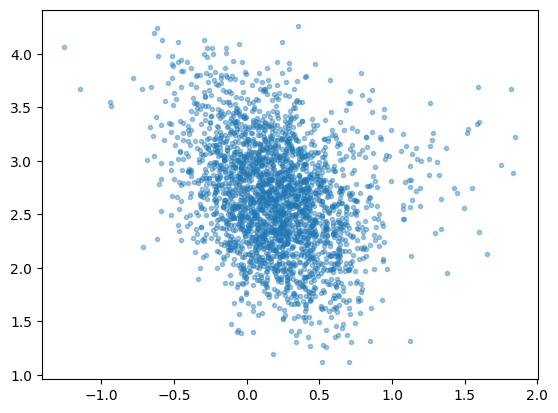

In [8]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

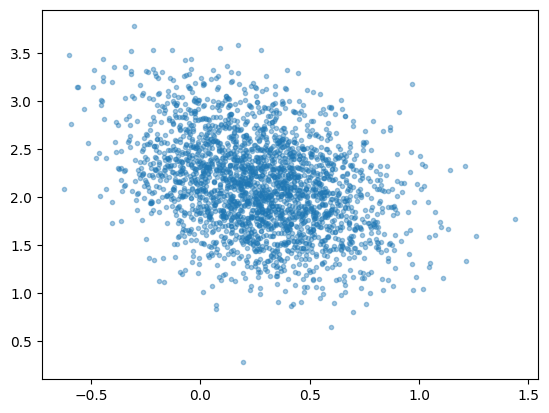

In [9]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [10]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(129.71533, dtype=float32)

In [11]:
results_dict["is_eval"]

[126.94927978515625,
 131.33070373535156,
 122.84772491455078,
 134.19766235351562,
 123.4433822631836,
 135.04934692382812,
 131.2591552734375,
 125.20929718017578,
 130.06915283203125,
 131.5062713623047,
 133.50277709960938,
 128.6240234375,
 128.314697265625,
 123.47052001953125,
 130.61265563964844,
 128.6016387939453,
 123.05453491210938,
 124.31976318359375,
 136.47349548339844,
 136.24237060546875,
 127.8902359008789,
 136.76580810546875,
 128.18466186523438,
 134.36732482910156,
 128.7330780029297,
 131.4500274658203,
 121.2936019897461,
 126.427978515625,
 135.2499542236328,
 136.01873779296875]

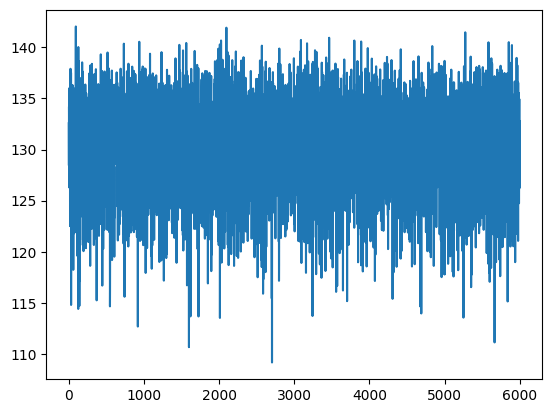

In [12]:
plt.plot(results_dict["is"])

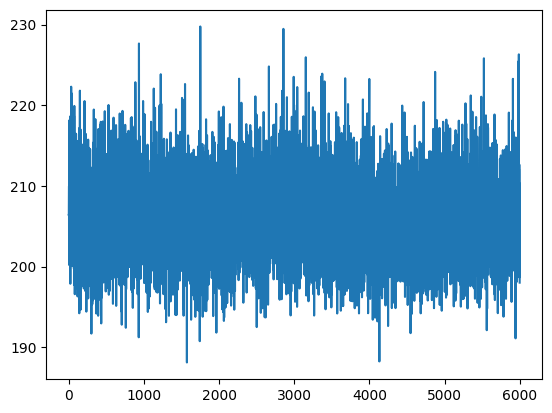

In [13]:
plt.plot(results_dict["elbo"])

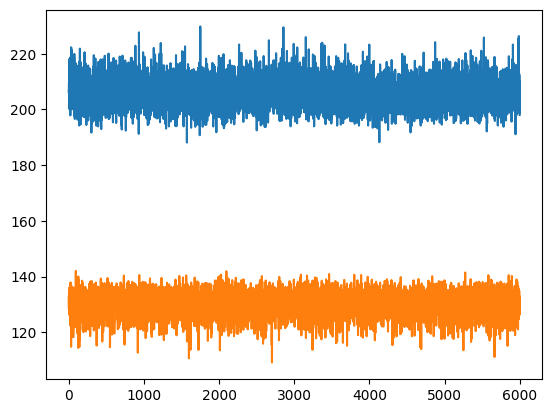

In [14]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])

In [15]:
jnp.array(results_dict["elbo_eval"]).mean()

DeviceArray(206.55162, dtype=float32)